In [2]:
# From https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

# TSP defined as: “Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?”
# Rules include:
# 1. Each city needs to be visited exactly one time
# 2. We must return to the starting city, so our total distance needs to be calculated accordingly

In [3]:
# Gene = City (x, y) coordinates
# Individual (aka Chromosome) = single route satisfying above conditions
# Population = collection of possible routes (i.e. collection of chromosomes)
# Parents = 2 routes that are combined to create a new route
# Mating pool = collection of parents that are used to create our next population (thus creating the next gen of routes)
# Fitness = function that tells us how good each route is (in our case, how short the distance is)
# Mutation = a way to introduce variation in our population by randomly swapping two cities in the route
# Elitism = a way to carry the best individuals into the next generation

In [4]:
# Steps:
# 1. Create the population
# 2. Determine the fitness
# 3. Select the mating pool
# 4. Breed
# 5. Mutate
# 6. Repeat

In [5]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# City class allows us to create and handle our cities.
# Cities represented as (x, y) coordinates.
# Use pythagorean theorem to calculate distance to another city.
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [7]:
# Fitness class.  Treat fitness as inverse of the route distance.
# We want to minimize route distance, so larger fitness is better.
# Recall that we must start and end in the same location.
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0
        
    def routeDistance(self):
        """
        Iterate through the route and accumulate the
        pathDistance.
        """
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    # If have not completed the route, go to next hop.
                    toCity = self.route[i + 1]
                else:
                    # Completed route. Back to start location.
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        """
        Return inverse of distance.
        We want to minimize distance, so larger fitness is better.
        """
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [8]:
# Now create the initial population (aka the first generation).
# We need a function that produces routes that satisfy the necessary conditions.

def createRoute(cityList):
    """
    Create an individual (aka chromosome).
    """
    route = random.sample(cityList, len(cityList))
    return route


In [9]:
def initialPopulation(popSize, cityList):
    """
    Create the initial population. Future generations created
    through breeding and mutation.
    """
    population = []
    
    for i in range(0, popSize):
        population.append(createRoute(cityList))
    
    return population

In [10]:
# Determine the fitness.
# Rank the fitness of each individual in the population.
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0, len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    
    # Return ordered list with the route IDs and each associated fitness score.
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [11]:
# Select the mating pool.
# There are a few options for how to select the parents that will be used to create the next generation.
# Most common approaches are "fitness proportionate selection" (aka "roulette wheel selection") or "tournament selection"

# Fitness proportionate selection (version implemented below):
# Fitness of each individual relative to the population is used to assign
# a probability of selection. Think of this as a fitness-weighted
# probability of being selected.

# Tournament selection:
# A set number of individuals are randomly selected from the population and
# the one with the highest fitness in the group is chosen as the first
# parent. This is repeated to choose the second parent.

# Another design feature is the use of elitism.
# With elitism, the best performing individuals from the population will
# automatically carry over to the next generation, ensuring that the most
# successful individuals persist.

def selection(popRanked, eliteSize):
    """
    Use output from rankRoutes to determine which routes to select.
    """
    selectionResults = []
    # Set up roulette wheel by calculating a relative fitness
    # weight for each individual.
    df = pd.DataFrame(np.array(popRanked), columns=["Index", "Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    # Introduce elitism to hold onto the best routes.
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    
    # Compare a randomly drawn number to these weights to select our mating pool
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for j in range(0, len(popRanked)):
            if pick <= df.iat[j,3]:
                selectionResults.append(popRanked[j][0])
                break
    
    return selectionResults

In [12]:
# Now that we have the IDs of the routes that will make up the 
# mating pool from the selection function, we can create 
# the mating pool.

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [13]:
# With the mating pool created, now we breed (aka crossover).
# If had a string of 0's and 1's then we simply pick a crossover
# point and splice the two strings together.
# However, for TSP we need to include all locations exactly once.
# Therefore, we need to do a special breeding function called
# ordered crossover.

# In ordered crossover, we randomly select a subset of the first parent
# string and then fill the remainder of the route with the genes from
# the second parent in the order in which they appear, without
# duplicating any genes in the selected subset from the first parent.
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    # Get random genes from parent 1.
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    # Determine starting and ending gene.
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    
    # Get genes from parent1
    for i in range(startGene, endGene):
        childP1.append(parent1[i])
    
    # Get remaining genes from parent2
    childP2 = [item for item in parent2 if item not in childP1]
    
    # Combine genes
    child = childP1 + childP2
    return child

In [14]:
# Generalize this to create our offspring population.

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))
    
    # Use elitism to retain the best routes from current population.
    for i in range(0, eliteSize):
        children.append(matingpool[i])
    
    # Use breed function to fill out the rest of the next generation.
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [16]:
# Mutation helps to avoid local convergence and introduces
# novel routes that allow us to explore other parts of the solution
# space.

# If we had a string of 0's and 1's then mutation would simply mean
# assigning a low probability of a gene changing from 0 to 1 or vice versa.

# However, since we must visit all cities we can't drop any.
# Instead we use swap mutation.
# Swap mutation means with specified low probability, two cities will
# swap places in the route.

def mutate(individual, mutationRate):
    """
    Swap mutate one individual.
    """
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    
    return individual

In [23]:
def mutatePopulation(population, mutationRate):
    """
    Mutate the new population.
    """
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    
    return mutatedPop

In [24]:
# Now need to combine the above to create a function that produces
# a new generation.

# 1. Rank routes in current generation with rankRoutes()
# 2. Determine potential parents by running selection()
# 3. This allows us to create the mating pool using matingPool()
# 4. Create new generation using breedPopulation()
# 5. Apply mutation using mutatePopulation()

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [25]:
# Now we can create the Genetic Algorithm
# Create the initial population, then loop through as many
# generations as we desire.

def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    # Distance is inverse of the fitness
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    # Go through all generations.
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [26]:
# Now we need to create our city list.
cityList = []

# Create 25 random cities.
for i in range(0, 25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

In [27]:
# Run the genetic algorithm.
# 100 individuals in each generation
# 20 elite individuals
# 1% mutation rate for a given gene
# Run through 500 generations

geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

Initial distance: 2283.8200369602314
Final distance: 924.7733511372774


[(55,154),
 (89,142),
 (107,148),
 (110,128),
 (143,139),
 (143,175),
 (171,188),
 (177,180),
 (173,89),
 (194,80),
 (186,46),
 (190,42),
 (181,1),
 (163,3),
 (97,44),
 (137,73),
 (99,90),
 (68,62),
 (39,67),
 (31,27),
 (13,56),
 (20,125),
 (31,126),
 (5,187),
 (49,153)]

In [28]:
# Now create it so that it plots the progress with each generation.
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

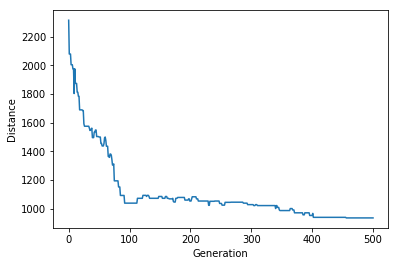

In [29]:
# Run algorithm and see plot
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)